# **Задача Look-a-Like**

## **1 | Вводная**

***


#### **Задача look-a-like**

Цель задачи look-a-like заключается в том что вы хотим найти похожих пользователей. 

- Это нужно для того чтобы можно было сегментировать пользователей и предпринимать какие то последующие действия на основе этой информации

#### **Задача предсказания оттока**

Будем строить модель для определения клиентов которые могут уйти  

- Задачу look-a-like будем решать на примере поиска сегмента клиентов, **`склонных к оттоку`** из банка.
- Датасет содержит ретро-данные о клиентах, оттекших из банка - целевой сегмент. Аналогично - имеются данные о тех, кто не оттек.
- Необходимо для любого другого клиента из тестовой выборки определить вероятность (склонность к оттоку).

**Задача**: построить модель классификации с предельно большим значением ROC-AUC



***

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

# Установка настроек для отображения всех колонок и строк при печати
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# заранее установим в константу random_state
random_state = 47

sns.set(style="whitegrid")

## **2 | Чтение данных**

In [ ]:
churn = pd.read_csv('/content/Churn_Modelling.csv')
print(churn.shape)
churn.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### **Признаки**

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

#### **Целевой признак**

- `Exited` — факт ухода клиента (1 - Отток)

Сразу исключим ненужные столбцы, чтобы модели не переобучались под пользователей:

In [ ]:
churn = churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0



## **3 | Визуализация Данных**

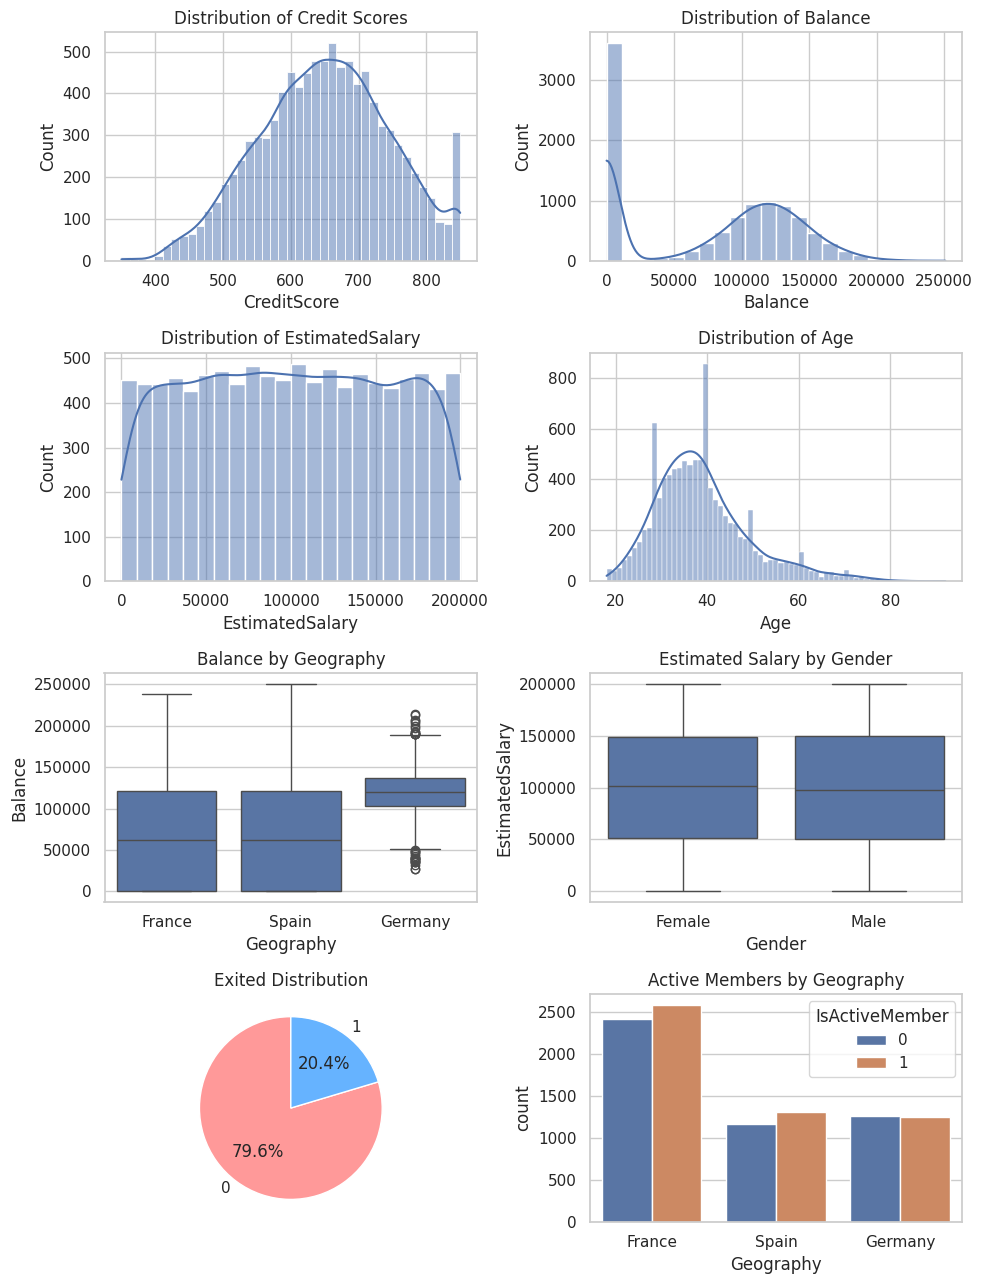

In [ ]:
# Создание подграфиков
fig, axes = plt.subplots(4, 2, figsize=(10, 13))

# Гистограмма кредитных баллов
sns.histplot(data=churn, x='CreditScore', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Credit Scores')

# Гистограмма баланса на счёте
sns.histplot(data=churn, x='Balance', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Balance')

# Гистограмма зарплат
sns.histplot(data=churn, x='EstimatedSalary', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of EstimatedSalary')

# Гистограмма возраста
sns.histplot(data=churn, x='Age', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Age')

# Боксплот баланса по странам
sns.boxplot(x='Geography', y='Balance', data=churn, ax=axes[2, 0])
axes[2, 0].set_title('Balance by Geography')

# Боксплот зарплаты по полу
sns.boxplot(x='Gender', y='EstimatedSalary', data=churn, ax=axes[2, 1])
axes[2, 1].set_title('Estimated Salary by Gender')

# Круговая диаграмма для колонки Exited (отточников)
exited_counts = churn['Exited'].value_counts()
axes[3, 0].pie(exited_counts, labels=exited_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
axes[3, 0].set_title('Exited Distribution')

# Распределение активных членов по странам
sns.countplot(x='Geography', hue='IsActiveMember', data=churn, ax=axes[3, 1])
axes[3, 1].set_title('Active Members by Geography')

# Подгонка и отображение графиков
plt.tight_layout()
plt.show()

## **4 | Предобработка**

#### **Кодировка категориальный признаков**

- В данных есть категориальные и количественные признаки. 
- Ко всему датасету применим **One-Hot Endoding** и будем использовать для всех моделей


Далее будем обучать следующие модели: 

- Логистическую регрессию
- SVM
- Решающее дерево
- Случайный лес
- Бустинг

In [ ]:
# One-Hot для логрега (для зелени тоже подходит)
churn = pd.get_dummies(churn, drop_first=True)
print(churn.shape)
churn.head()

(10000, 12)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


## **5 | Train/Test подвыборки**

Делим на выборки:

In [ ]:
features = churn.drop(['Exited'], axis=1)
target = churn['Exited']

In [ ]:
# мощность классов
target.value_counts()

,count
Exited,
0,7963
1,2037


In [ ]:
target.mean()

0.2037

In [ ]:
# отделяем 20% - пятую часть всего - на тестовую выборку
X_train_valid, X_test, y_train_valid, y_test = train_test_split(features, target,
                                                                            test_size=0.2,
                                                                            random_state=random_state)
# отделяем 25% - четвертую часть трейн+валид - на валидирующую выборку
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid,
                                                                              test_size=0.25,
                                                                              random_state=random_state)

s1 = y_train.size
s2 = y_valid.size
s3 = y_test.size
print('Разбиение на выборки train:valid:test в соотношении '
      + str(round(s1/s3)) + ':' + str(round(s2/s3)) + ':' + str(round(s3/s3)))

Разбиение на выборки train:valid:test в соотношении 3:1:1


In [ ]:
targets = [y_train, y_train_valid, y_valid, y_test]
names = ['train:', 'train+valid:', 'valid:', 'test:']
print('Баланс классов на разбиениях:\n')
i = 0
for target in targets:
    pc = target.mean()
    print(names[i], pc.round(3))
    i += 1

Баланс классов на разбиениях:

train: 0.201
train+valid: 0.202
valid: 0.204
test: 0.212


## **6 | Маштабирование**


- Среди моделей, выбранных для исследования, есть линейные; Качество линейных алгоритмов зависит от масштаба данных. Признаки должны быть нормализованы. 
- Если масштаб одного признака сильно превосходит масштаб других, то качество может резко упасть. 
- Для нормализации используем стандартизацию признаков: возьмем набор значений признака на всех объектах, вычислим их среднее значение и стандартное отклонение. 
- После этого из всех значений признака вычтем среднее, и затем полученную разность поделим на стандартное отклонение. Сделает это StandardScaler()...

In [ ]:
# Выделяем количественные признаки для стандартизации
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Параметры стандартизации получим на трейне
scaler = StandardScaler()
scaler.fit(X_train[numeric])

# Преобразуем все выборки на основе параметров, полученных выше
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

X_train_valid[numeric] = scaler.fit_transform(X_train_valid[numeric])

In [ ]:
X_train[numeric].describe().round(3)

,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,6000.000,6000.000,6000.000,6000.000,6000.000
mean,0.000,0.000,0.000,-0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000
min,-3.136,-1.994,-1.730,-1.236,-1.753
25%,-0.690,-0.663,-0.695,-1.236,-0.860
50%,0.007,-0.187,-0.004,0.335,0.009
75%,0.693,0.478,1.031,0.821,0.855
max,2.067,5.042,1.721,2.807,1.729


- Значения по выбранным количественным признакам теперь выглядят немного неадекватно,
- зато с нулевым средним и среднеквадратичным, равным 1.

In [ ]:
# Функция для оценки модели
def calc_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test):

    # Обучение
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_train)

    # Валидация
    y_valid_pred = model.predict(X_valid)
    y_valid_proba = model.predict_proba(X_valid)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_valid)

    # Тестирование
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    train_metrics = {
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'roc_auc': roc_auc_score(y_train, y_train_proba)
    }

    valid_metrics = {
        'precision': precision_score(y_valid, y_valid_pred),
        'recall': recall_score(y_valid, y_valid_pred),
        'f1': f1_score(y_valid, y_valid_pred),
        'roc_auc': roc_auc_score(y_valid, y_valid_proba)
    }

    test_metrics = {
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba)
    }

    return train_metrics, valid_metrics, test_metrics

def print_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    res = calc_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test)
    metrics = pd.DataFrame(res, index=['train', 'valid', 'test']).round(3)
    return metrics

## **7 | Маштабирование**

#### <b>Логистическая Регрессии</b>

**Оптимизация Гиперпараметров**

Будем использовать стандартную переборку параметров с GridSearchCV

In [ ]:
%%time

"""

Ручной перебор всех комбинации параметров

- наилучшию модель выбираем по метрике ROC-AUC

"""

param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],      # Тип регурелизации
    # 'solver': ['lbfgs', 'liblinear', 'saga'],
    'C': np.linspace(0.001, 2, 50)  # Параметр который отвечает за вес этих поправок
}

grid_search = GridSearchCV(LogisticRegression(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)

grid_search.fit(X_train_valid, y_train_valid)

best_logreg = grid_search.best_estimator_
print(best_logreg.get_params())

{'C': 0.04179591836734694, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
CPU times: user 632 ms, sys: 143 ms, total: 774 ms
Wall time: 7.9 s


In [ ]:
res_logreg = print_metrics(best_logreg, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_logreg

,precision,recall,f1,roc_auc
train,0.615,0.201,0.303,0.774
valid,0.617,0.174,0.272,0.765
test,0.644,0.201,0.306,0.754


In [ ]:
# Получение коэффициентов модели
coef = best_logreg.coef_[0]

# Создание DataFrame для коэффициентов и признаков
coef_df = pd.DataFrame({
    'Feature': X_train_valid.columns,
    'Coefficient_logreg': coef.round(3)
})

# Добавление столбца с интерпретацией
coef_df['Interpretation_logreg'] = coef_df['Coefficient_logreg'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

**Интерпретация Важности Признаков**

Для линейной модели важность признаков можно оценить по значению весов

- **Positive**: Если коэффициент положительный, это означает, что увеличение значения признака увеличивает вероятность положительного исхода.
- **Negative**: Если коэффициент отрицательный, это означает, что увеличение значения признака уменьшает вероятность положительного исхода.

In [ ]:
coef_df

,Feature,Coefficient_logreg,Interpretation_logreg
0,CreditScore,-0.064,Negative
1,Age,0.738,Positive
2,Tenure,-0.032,Negative
3,Balance,0.169,Positive
4,NumOfProducts,-0.128,Negative
5,HasCrCard,-0.019,Negative
6,IsActiveMember,-0.975,Negative
7,EstimatedSalary,0.047,Positive
8,Geography_Germany,0.707,Positive
9,Geography_Spain,0.021,Positive


#### <b>Метод Опорных Векторов</b>



In [ ]:
%%time

"""

- Будем исходить из предположений что в данных есть нелинейность, проверим линейное ядро и полиномиальное
- probability = True : На выходе вероятностное расспределение

'kernel': 'poly' говорит нам о том что полиномиалное ядно дает лучше результат
Из этого мы однозначно делаем вывод что в данных есть нелинейность


"""

param_grid = {
    # 'C': np.linspace(0.001, 2, 50),
    # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'kernel': ['linear', 'poly']

}

grid_search = GridSearchCV(SVC(random_state=42, probability=True, gamma='scale'),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)

grid_search.fit(X_train_valid, y_train_valid)

best_SVC = grid_search.best_estimator_
print(best_SVC.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
CPU times: user 9.52 s, sys: 305 ms, total: 9.82 s
Wall time: 52.1 s


In [ ]:
res_SVC = print_metrics(best_SVC, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_SVC

,precision,recall,f1,roc_auc
train,0.856,0.247,0.383,0.825
valid,0.885,0.246,0.385,0.841
test,0.850,0.241,0.376,0.812


**Интерпритация Важность Признаков**

Permutation Importance

- Интерпретировать веса у полиномиальной модели как с линейной мы не сможем
- Воспользуемся другим подходом permutation importance
- Она смотрит на важность признака в контексте
    - Приставим приннак h
    - PI перемешивает все значение в этом столбце (получается что он испортил колонку)
    - Обучает модель с учетом испорченной фичи
    - запоминаем качество модели и запоминаем ее
    - анологично делаем для всех остальных колонок
    - чем сильнее падает качество при перемешенной колонки тем больше вклад признака в модели



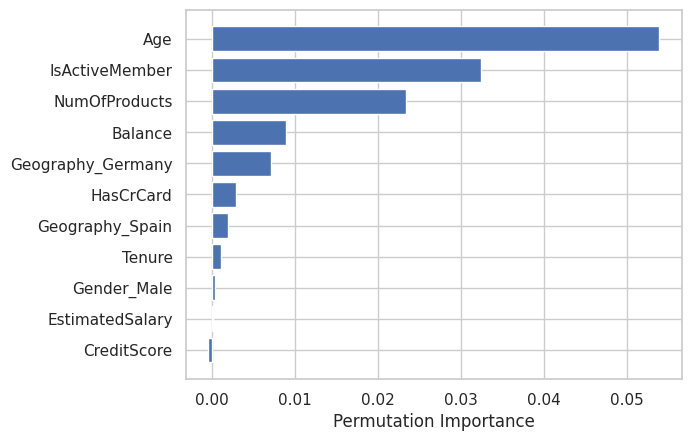

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_SVC, X_test, y_test)

features = np.array(X_test.columns)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

#### <b>Решающее Дерево</b>


**Параметры**

- `criterion` : Критерии на основе которого происходит разбиение на два класса , отвечает за характер разбиения
- max_depth : максимальная глубина дерева
- min_samples_leaf : Минимальное количество рядов в предсказаниях


In [ ]:
%%time

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    # 'splitter': ['best', 'random'],
    'max_depth': range(1, 11),
    # 'min_samples_split': range(2, 10),
    'min_samples_leaf': range(2, 10)
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)

grid_search.fit(X_train_valid, y_train_valid)

best_tree = grid_search.best_estimator_
print(best_tree.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 9, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
CPU times: user 1.17 s, sys: 127 ms, total: 1.29 s
Wall time: 31.1 s


In [ ]:
res_tree = print_metrics(best_tree, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_tree

,precision,recall,f1,roc_auc
train,0.767,0.485,0.594,0.868
valid,0.813,0.459,0.587,0.869
test,0.744,0.440,0.553,0.841


In [ ]:
def plot_importance(model, X):

  # Получение важности признаков
  feature_importances = model.feature_importances_

  # Создание DataFrame для важности признаков
  importance_df = pd.DataFrame({
      'Feature': X.columns,
      'Importance': feature_importances
  })

  # Сортировка DataFrame по важности
  importance_df = importance_df.sort_values(by='Importance', ascending=False)

  # Визуализация важности признаков
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Importance', y='Feature', data=importance_df)
  plt.title('Feature Importances in Decision Tree')
  plt.show()

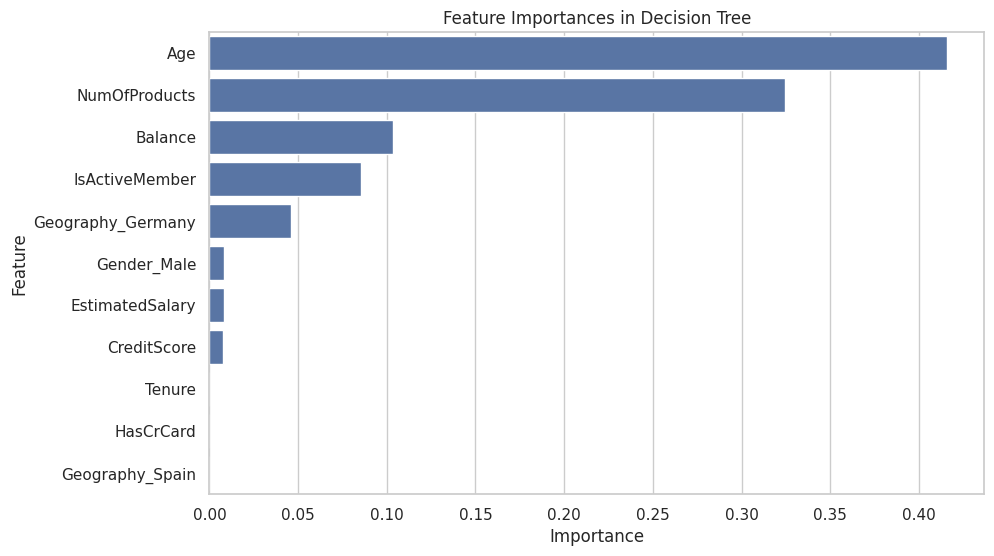

In [ ]:
plot_importance(best_tree, X_train_valid)

#### <b>Случайный Лес</b>

**Оптимизация Гиперпараметров**

- оптимизатор для подбора параметров
- оптимизатор использует байевскую оптимизацию

In [ ]:
!pip install optuna -qqq

In [ ]:
import optuna

# оптимизируем
def objective(trial):

    # гиперпараметры случайного леса
    param = {
        'criterion': trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
        'n_estimators': trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 2, 10), # сократить кол-во деревьев
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 10),

    }

    model = RandomForestClassifier(**param, random_state=random_state)
    model.fit(X_train, y_train)

    preds = model.predict_proba(X_valid)[:,1]
    auc = roc_auc_score(y_valid, preds)

    return auc

In [ ]:
# максимизируем roc-auc
study = optuna.create_study(direction="maximize", 
                            study_name='RandomForestClassifier')
study.optimize(objective, n_trials=10) # попробовать увеличить

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-14 03:46:14,901] A new study created in memory with name: RandomForestClassifier
[I 2024-08-14 03:46:15,008] Trial 0 finished with value: 0.8334212486754861 and parameters: {'criterion': 'log_loss', 'n_estimators': 15, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8334212486754861.
[I 2024-08-14 03:46:15,213] Trial 1 finished with value: 0.8172085799204443 and parameters: {'criterion': 'gini', 'n_estimators': 38, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8334212486754861.
[I 2024-08-14 03:46:15,408] Trial 2 finished with value: 0.8193139210088363 and parameters: {'criterion': 'log_loss', 'n_estimators': 17, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8334212486754861.
[I 2024-08-14 03:46:16,070] Trial 3 finished with value: 0.8264767078326399 and parameters: {'criterion': 'log_loss', 'n_estimators': 61, 'max_depth': 2, 'min_sa

Number of finished trials: 10
Best trial:
Value: 0.8498282566079176
Params: 
    criterion: gini
    n_estimators: 68
    max_depth: 9
    min_samples_split: 6
    min_samples_leaf: 9


In [ ]:
# Обучаем модель с оптимальными параметрами 
best_forest = RandomForestClassifier(**study.best_params, random_state=random_state)
best_forest.fit(X_train_valid, y_train_valid)

res_forest = print_metrics(best_forest, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_forest

,precision,recall,f1,roc_auc
train,0.863,0.463,0.603,0.914
valid,0.894,0.477,0.622,0.908
test,0.795,0.411,0.542,0.857


**Интерпретация Важности Признаков**

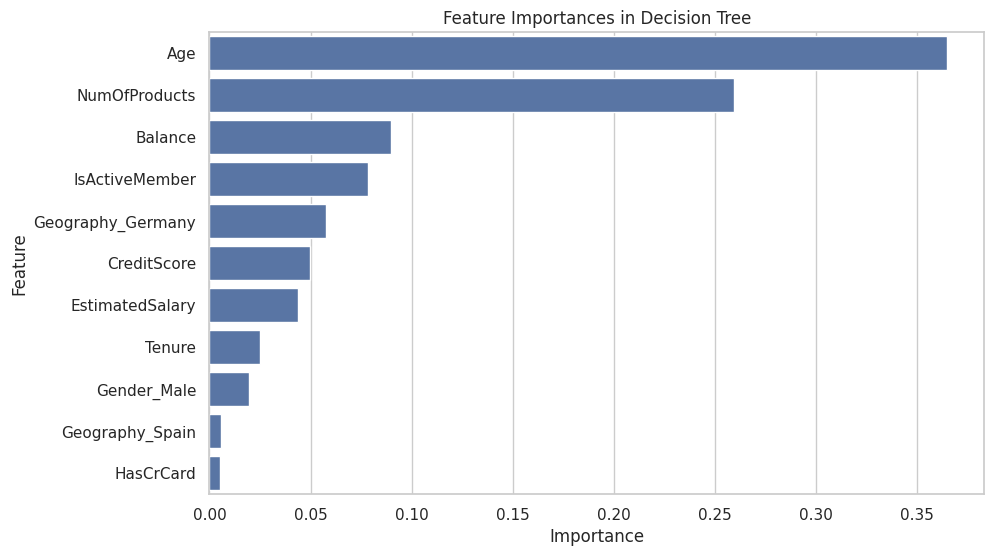

In [ ]:
plot_importance(best_forest, X_train_valid)

#### <b>Градиентный Бустинг</b>

Выбор гиперпараметров 

- **learning_Rate** : Скорость обучения, определяющая, насколько сильно обновляются веса модели на каждом шаге
- **max_depth** : Максимальная глубина деревьев решений
- **l2_leaf_reg** : Регуляризация L2 для листьев деревьев
- **subsample** : Доля выборки, используемая для обучения каждого дерева
- **random_strength** 
    - Параметр, отвечающий за случайность в процессе построения деревьев 
    - Он влияет на то, насколько сильно случайные изменения влияют на процесс разделения данных в каждом узле дерева

- **min_data_in_leaf** : Минимальное количество данных, необходимых для создания листа в дереве.

**Определение целевой функции**

Нам нужно задать функцию которую мы будем оптимитизировать 

In [ ]:
from catboost import CatBoostClassifier

def objective(trial):
    param = {
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.9),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "l2_leaf_reg":trial.suggest_float('l2_leaf_reg', 0.01, 2),
        "subsample": trial.suggest_float('subsample', 0.01, 1),
        "random_strength": trial.suggest_float('random_strength', 1, 200),
        "min_data_in_leaf":trial.suggest_float('min_data_in_leaf', 1, 500)
    }

    cat = CatBoostClassifier(
        logging_level="Silent",
        eval_metric="AUC",
        grow_policy="Lossguide",
        random_seed=42,
        **param)
    cat.fit(X_train, y_train,
            eval_set=(X_valid, y_valid),
            verbose=False,
            early_stopping_rounds=10
           )

    preds = cat.predict_proba(X_valid)[:,1]
    auc = roc_auc_score(y_valid, preds)

    return auc

Создаем объект исследования и запускаем оптимизацию

In [ ]:
study = optuna.create_study(direction="maximize", study_name='CatBoostClassifier')
study.optimize(objective, n_trials=100) # попробуйте увеличить

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-14 03:46:44,732] A new study created in memory with name: CatBoostClassifier
[I 2024-08-14 03:46:44,948] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 0.2165534023121395, 'max_depth': 2, 'l2_leaf_reg': 1.5477322039068058, 'subsample': 0.029345419918240072, 'random_strength': 6.5809964961892495, 'min_data_in_leaf': 477.52416517082804}. Best is trial 0 with value: 0.5.
[I 2024-08-14 03:46:45,339] Trial 1 finished with value: 0.8372625321777863 and parameters: {'learning_rate': 0.789728112113311, 'max_depth': 4, 'l2_leaf_reg': 0.6004269201561995, 'subsample': 0.55359191980997, 'random_strength': 46.57861106355321, 'min_data_in_leaf': 425.7303912933811}. Best is trial 1 with value: 0.8372625321777863.
[I 2024-08-14 03:46:45,992] Trial 2 finished with value: 0.8485835604479672 and parameters: {'learning_rate': 0.4634724182719374, 'max_depth': 6, 'l2_leaf_reg': 0.575436612277608, 'subsample': 0.42186545862300934, 'random_strength': 123.97404853733563, 'min_dat

Number of finished trials: 100
Best trial:
Value: 0.8579966715559936
Params: 
    learning_rate: 0.2275828875803787
    max_depth: 2
    l2_leaf_reg: 1.649969257251929
    subsample: 0.41432801712540723
    random_strength: 9.871440937029153
    min_data_in_leaf: 339.4206240957627


In [ ]:
best_cat = CatBoostClassifier(**study.best_params, random_state=random_state)
best_cat.fit(X_train, y_train,
            eval_set=(X_valid, y_valid),
            verbose=False,
             early_stopping_rounds=10
           )

res_cat = print_metrics(best_cat, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_cat

,precision,recall,f1,roc_auc
train,0.786,0.468,0.587,0.877
valid,0.825,0.464,0.594,0.855
test,0.754,0.442,0.557,0.856


**Интерпретация Важности Признаков**

Для градиентного спуска можно использовать `SHAP` значении для интерпретации важности признаков 

- Чем выше признак, тем он важнее
- Чем краснее точка, тем выше значение признака 

SHAP value

- Значения SHAP представляют собой вклад каждого признака в прогноз модели. 
- Положительные значения SHAP указывают на то, что признак увеличивает прогноз (в сторону положительного класса; отток клиента)

Расспределение Точек

- Распределение точек для каждого признака показывает изменчивость влияния этого признака на прогнозы для различных экземпляров. 
- Более широкое распределение указывает на то, что признак имеет разное влияние в зависимости от других факторов.

In [ ]:
import shap
explainer = shap.TreeExplainer(best_cat)
shap_values = explainer(X_train_valid)

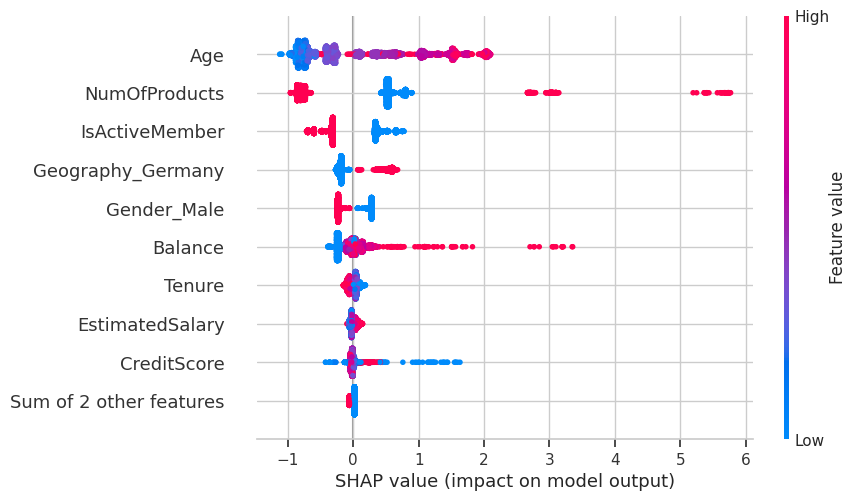

In [ ]:
shap.plots.beeswarm(shap_values)